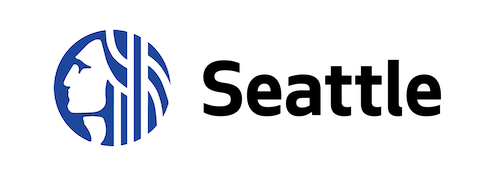


<h1><center> NOTEBOOK CONSOMMATION ENERGIE
   

Objectif : vous voulez tenter de prédire la consommation totale d’énergie de bâtiments non destinés à l’habitation.

# Sommaire <a id="0"></a>



I.  [Importation des librairies et données](#1)<br>

II.  [Préparation du jeu de données](#2)<br>

III.  [Regression linéaire simple](#3) <br>

IV. [Ridge regression ](#4)<br>

V. [Lasso  ](#5)<br>

VI. [Kernel regression](#6)<br>

VII. [Arbre de décision](#7)<br>

VIII. [Gradient boosting regression](#8)<br>



IX. [Intérêt Energy Star Score](#9) <br>



# Import files and librairies <a id="1"></a>

In [1]:
#import necessary libraries for scientific computation and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import libraries for regression & metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#import libraries for preprocessing and feature engineering
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.compose import TransformedTargetRegressor
#import libraries for cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge # Kernel regression
#librairies for decision trees
from sklearn import tree 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance #model inspection


# II. Préparation du jeu données <a id="2"></a>

In [2]:
#import file
benchmark_NR=pd.read_csv("benchmark_NR.csv")

In [3]:
benchmark_NR.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SteamUse(%),Electricity(%),NaturalGas(%),Age
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,60.0,7456910.0,2003882.00,3946027.0,1276453.0,249.98,27.730162,54.605993,17.663838,89
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,61.0,8664479.0,0.00,3242851.0,5145082.0,295.86,0.000000,38.660907,61.339093,20
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,43.0,73937112.0,21566554.00,49526664.0,1493800.0,2089.28,29.711308,68.230741,2.057944,47
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,56.0,6946800.5,2214446.25,2768924.0,1811213.0,286.43,32.591344,40.751928,26.656717,90
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,75.0,14656503.0,0.00,5368607.0,8803998.0,505.01,0.000000,37.880168,62.119825,36


**transformation des variables**

Nous utilisons la fonction log(1 + x) pour transformer les colonnes indiquant la surface dont la distribution était étallée à droite.
Nous allons aussi transformer la cible avec la même fonction.

In [4]:
for col in ['PropertyGFATotal',
            'PropertyGFABuilding(s)',
            'PropertyGFAParking',
            'LargestPropertyUseTypeGFA',
            'SecondLargestPropertyUseTypeGFA',
            'ThirdLargestPropertyUseTypeGFA',
            ]:
    benchmark_NR[col+'_tr']=np.log1p(benchmark_NR[col])

In [5]:
#sélection des colonnes
col_x=['Neighborhood',
    'NumberofBuildings',
    'NumberofFloors', 
    'LargestPropertyUseType', 
    'SteamUse(%)', 
    'Electricity(%)', 
    'NaturalGas(%)', 
    'Age',
    'PropertyGFATotal_tr', 
    'PropertyGFABuilding(s)_tr', 
    'PropertyGFAParking_tr', 
    'LargestPropertyUseTypeGFA_tr'
      ]
X_CO2=benchmark_NR.loc[:,col_x]
y_CO2=benchmark_NR.loc[:,'SiteEnergyUseWN(kBtu)']

**train_test split**

In [6]:
X_CO2_train,X_CO2_test,y_CO2_train,y_CO2_test=train_test_split(X_CO2,y_CO2, test_size=0.25, random_state=2022)
X_CO2_train.shape

(1248, 12)

**Normalisation des variables numériques & encodage des variables catégorielles**

Nous allons utiliser OneHotEncoder pour transformer les variables catégorielles en dummy variable et procéder au centrage et à la réduction des données numériques

In [7]:
ct = make_column_transformer(
    (preprocessing.StandardScaler(),
     make_column_selector(dtype_include=np.number)),  # colonnes numériques
    (OneHotEncoder(handle_unknown='ignore'),
     make_column_selector(dtype_include=object)))  # colonnes catégorie

X_CO2_train_tr=ct.fit_transform(X_CO2_train) 
X_CO2_test_tr=ct.transform(X_CO2_test)

Afin d'améliorer la lisibilité récupérons les noms des features et simplifions les noms

In [8]:
# récupérons les noms des features
features=pd.Series(ct.get_feature_names_out()).str.replace('PropertyUseType', 'PTU').str.split('__', expand=True).loc[:,1]

[Retour au sommaire](#0)<br>

# III. Regression simple <a id="3"></a>

## **Définition du modèle**

On définit un modèle de régression avec transformation de la cible `y` en log :

In [9]:
regressor = TransformedTargetRegressor(regressor=linear_model.LinearRegression(), func=np.log1p, inverse_func=np.expm1)

In [10]:
%%time
regressor.fit(X_CO2_train_tr, y_CO2_train)

Wall time: 9.97 ms


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression())

calculons un score moyen par cross validation afin de comparer

In [11]:
lr_cv = cross_validate(regressor,X_CO2_train_tr, y_CO2_train, cv=5,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
                       return_train_score=True,
                       return_estimator=True)

In [12]:
lr_cv

{'fit_time': array([0.0099268 , 0.00997353, 0.00766063, 0.00900149, 0.00793695]),
 'score_time': array([0.0009973 , 0.00099754, 0.0009973 , 0.00101233, 0.00099754]),
 'estimator': [TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                             regressor=LinearRegression()),
  TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                             regressor=LinearRegression()),
  TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                             regressor=LinearRegression()),
  TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                             regressor=LinearRegression()),
  TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                             regressor=LinearRegression())],
 'test_r2': array([ 3.44046716e-01,  1.78398199e-01, -1.34405693e+20,  2.76689975e-01,
         6.61608989e-01]),
 

la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [13]:
np.mean(lr_cv['test_r2'])

-2.6881138500796944e+19

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [14]:
y_CO2_pred_test=regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [15]:
conso_moy_train=np.mean(y_CO2_train)
conso_moy_test=np.mean(y_CO2_test)

In [16]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/consommation moyenne: %.2f" % (np.sqrt(error_train)/conso_moy_train))
print("MAE entrainement/consommation moyenne:: %.2f" % (mae_train/conso_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/consommation moyenne:: %.2f" % (np.sqrt( error_test)/conso_moy_test))
print("MAE test/consommation moyenne:: %.2f" % (mae_test/conso_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/consommation moyenne: 2.19
MAE entrainement/consommation moyenne:: 0.49
Coefficient de determination entrainement: 0.38 

RMSE test/consommation moyenne:: 1.45
MAE test/consommation moyenne:: 0.46
Coefficient de determination test: 0.68


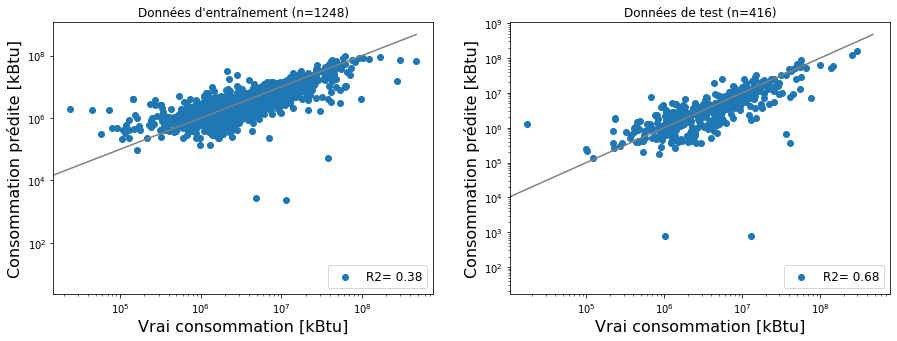

In [17]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vrai consommation [kBtu]', fontsize=16)
    ax.set_ylabel(u'Consommation prédite [kBtu]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## Analyse des variables qui influe le plus sur la regression

In [18]:
coeff=pd.DataFrame(regressor.regressor_.coef_, features, columns=['Coefficients']).sort_values('Coefficients', ascending=False)

<AxesSubplot:xlabel='Coefficients', ylabel='1'>

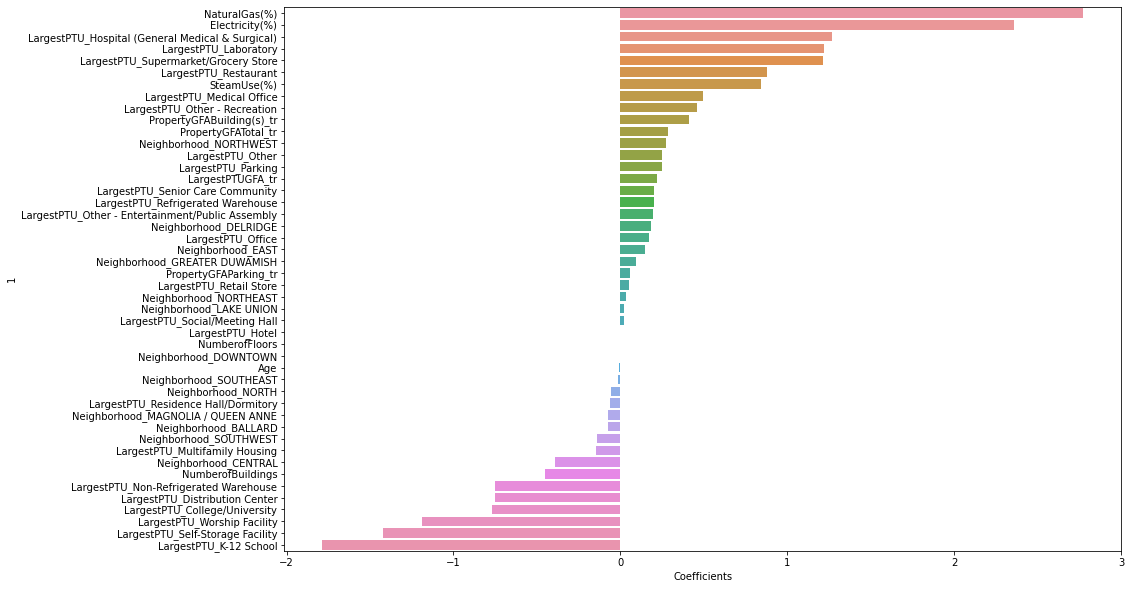

In [19]:
fig, ax1 =plt.subplots(figsize=(15,10))
sns.barplot(data=coeff, y=coeff.index,x='Coefficients')

[Retour au sommaire](#0)<br>

## IV. Ridge Regression <a id="4"></a>

## **Définition du modèle**

On définit un modèle de régression Ridge, avec transformation de la cible `y` en log :

In [20]:
regressor = TransformedTargetRegressor(regressor=linear_model.Ridge(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [21]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__copy_X', 'regressor__fit_intercept', 'regressor__max_iter', 'regressor__normalize', 'regressor__positive', 'regressor__random_state', 'regressor__solver', 'regressor__tol', 'regressor', 'transformer'])

In [22]:
# set different regularisation strengths
n_alphas = 300
alphas = np.logspace(-5, 5, n_alphas)

param_grid = {
    'regressor__alpha': alphas   
}

In [23]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    param_grid=param_grid, 
    cv=5, 
    verbose=True,
    refit='r2',
    return_train_score=True
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Wall time: 8.17 s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Ridge()),
             param_grid={'regressor__alpha': array([1.00000000e-05, 1.08005237e-05, 1.16651313e-05, 1.25989528e-05,
       1.36075289e-05, 1.46968439e-05, 1.58733611e-05, 1.71440614e-05,
       1.85164842e-05, 1.99987727e-05, 2.15997219e-05, 2.33288310e-05,
       2.51963593...
       3.15012480e+04, 3.40229977e+04, 3.67466194e+04, 3.96882735e+04,
       4.28654141e+04, 4.62968923e+04, 5.00030684e+04, 5.40059328e+04,
       5.83292359e+04, 6.29986298e+04, 6.80418197e+04, 7.34887289e+04,
       7.93716762e+04, 8.57255673e+04, 9.25881025e+04, 1.00000000e+05])},
             refit='r2', return_train_score=True,
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [24]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,234,233,235,232,236,237,231,238,230,239,...,14,34,12,22,26,8,21,32,13,42
mean_fit_time,0.002594,0.002774,0.002595,0.00281,0.002393,0.002784,0.002792,0.002982,0.002786,0.002582,...,0.004384,0.001614,0.004587,0.004382,0.004189,0.003992,0.004388,0.006705,0.004597,0.004189
std_fit_time,0.000491,0.000412,0.000491,0.000408,0.000473,0.000395,0.0004,0.000015,0.000397,0.00048,...,0.0005,0.001977,0.000488,0.000482,0.000399,0.000008,0.000488,0.008244,0.000497,0.000399
mean_score_time,0.000598,0.000814,0.000787,0.0008,0.000798,0.000607,0.000798,0.000408,0.000598,0.000803,...,0.000992,0.003335,0.000599,0.000998,0.000598,0.000599,0.001197,0.000199,0.000798,0.000798
std_score_time,0.000488,0.000408,0.000394,0.0004,0.000399,0.000496,0.000399,0.0005,0.000489,0.000401,...,0.00001,0.00617,0.000489,0.000001,0.000489,0.000489,0.000746,0.000399,0.000399,0.000399
param_regressor__alpha,670.01875,620.357648,723.655342,574.377375,781.585671,844.15346,531.805113,911.729948,492.388263,984.716096,...,0.000029,0.000137,0.000025,0.000054,0.000074,0.000019,0.00005,0.000118,0.000027,0.000254
params,{'regressor__alpha': 670.0187503509577},{'regressor__alpha': 620.3576476104269},{'regressor__alpha': 723.655342286965},{'regressor__alpha': 574.3773748826575},{'regressor__alpha': 781.585670768409},{'regressor__alpha': 844.1534596012976},{'regressor__alpha': 531.8051128214197},{'regressor__alpha': 911.7299484984921},{'regressor__alpha': 492.38826317067316},{'regressor__alpha': 984.7160957933764},...,{'regressor__alpha': 2.9391883986468844e-05},{'regressor__alpha': 0.00013712724343984008},{'regressor__alpha': 2.5196359293170134e-05},{'regressor__alpha': 5.442343548300272e-05},{'regressor__alpha': 7.405684692262442e-05},{'regressor__alpha': 1.851648417912154e-05},{'regressor__alpha': 5.0389626250651503e-05},{'regressor__alpha': 0.00011755310738783699},{'regressor__alpha': 2.7213387683753087e-05},{'regressor__alpha': 0.0002539114433680347}
split0_test_r2,0.091755,0.094173,0.089114,0.096389,0.086235,0.083106,0.09843,0.079722,0.100093,0.075921,...,0.338448,0.338341,0.338417,0.338537,0.338456,0.338536,0.33842,0.338384,0.338612,0.338563
split1_test_r2,0.065175,0.068699,0.061642,0.072212,0.058102,0.054559,0.075764,0.051014,0.079272,0.047477,...,0.186301,0.186363,0.186323,0.186304,0.186354,0.186355,0.186231,0.186401,0.186394,0.186349
split2_test_r2,0.025478,-0.006776,0.048918,-0.047557,0.066497,0.079374,-0.100456,0.088462,-0.168917,0.094484,...,-147745764486768558080.0,-147751039719920992256.0,-147763623420852600832.0,-147775093916840755200.0,-147785904698674249728.0,-147802090931355025408.0,-147813146701309804544.0,-147857085185289748480.0,-147859388275678117888.0,-148176514997094154240.0
split3_test_r2,0.310435,0.317158,0.30306,0.323269,0.295004,0.286249,0.328563,0.276319,0.333557,0.266257,...,0.276005,0.276027,0.276034,0.276059,0.276001,0.276003,0.275994,0.276031,0.27594,0.27601


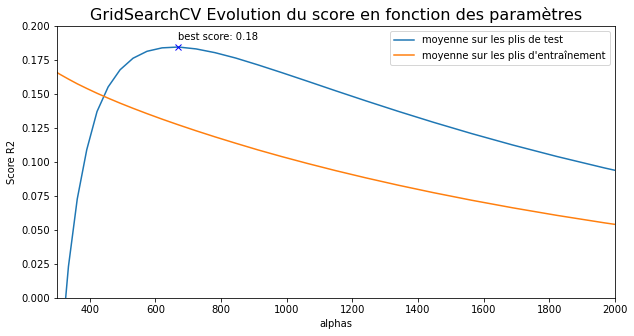

In [25]:
results=pd.DataFrame(grid_search.cv_results_)
fig1, ax =plt.subplots(figsize=(10,5))

plt.title("GridSearchCV Evolution du score en fonction des paramètres", fontsize=16)
plt.xlabel("alphas")
plt.ylabel("Score R2")

ax.set_xlim(300, 2000)
ax.set_ylim(0, 0.20)

ax.plot(results['param_regressor__alpha'], results['mean_test_r2'], label='moyenne sur les plis de test')
ax.plot(results['param_regressor__alpha'], results['mean_train_r2'], label="moyenne sur les plis d'entraînement" )
plt.legend(loc="best")

ax.plot(grid_search.best_params_['regressor__alpha'], grid_search.best_score_, marker='x', color='b')

 # Annotate the best score for that scorer
ax.annotate("best score: %0.2f" % grid_search.best_score_, (grid_search.best_params_['regressor__alpha'], grid_search.best_score_+0.005))

plt.show()

On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [26]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Ridge(alpha=670.0187503509577))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [27]:
best_regressor.regressor_.get_params()

{'alpha': 670.0187503509577,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [28]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [29]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/consommation moyenne: %.2f" % (np.sqrt(error_train)/conso_moy_train))
print("MAE entrainement/consommation moyenne:: %.2f" % (mae_train/conso_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/consommation moyenne:: %.2f" % (np.sqrt( error_test)/conso_moy_test))
print("MAE test/consommation moyenne:: %.2f" % (mae_test/conso_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/consommation moyenne: 2.59
MAE entrainement/consommation moyenne:: 0.61
Coefficient de determination entrainement: 0.13 

RMSE test/consommation moyenne:: 2.41
MAE test/consommation moyenne:: 0.64
Coefficient de determination test: 0.13


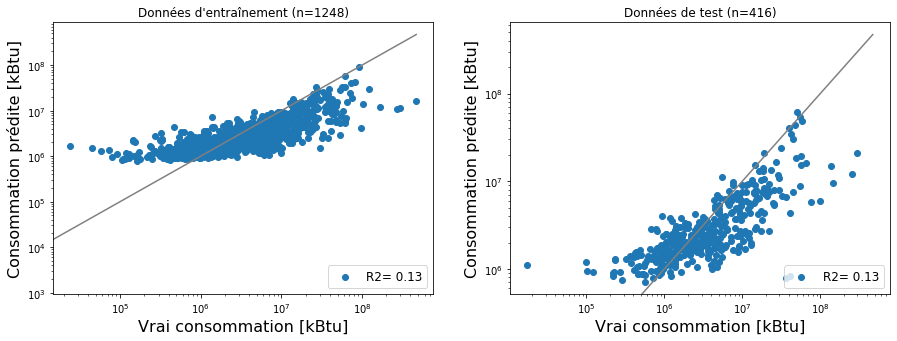

In [30]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vrai consommation [kBtu]', fontsize=16)
    ax.set_ylabel(u'Consommation prédite [kBtu]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## Analyse des variables qui influent le plus sur la regression

In [31]:
coeff=pd.DataFrame(best_regressor.regressor_.coef_, features, columns=['Coefficients']).sort_values('Coefficients', ascending=False)

<AxesSubplot:xlabel='Coefficients', ylabel='1'>

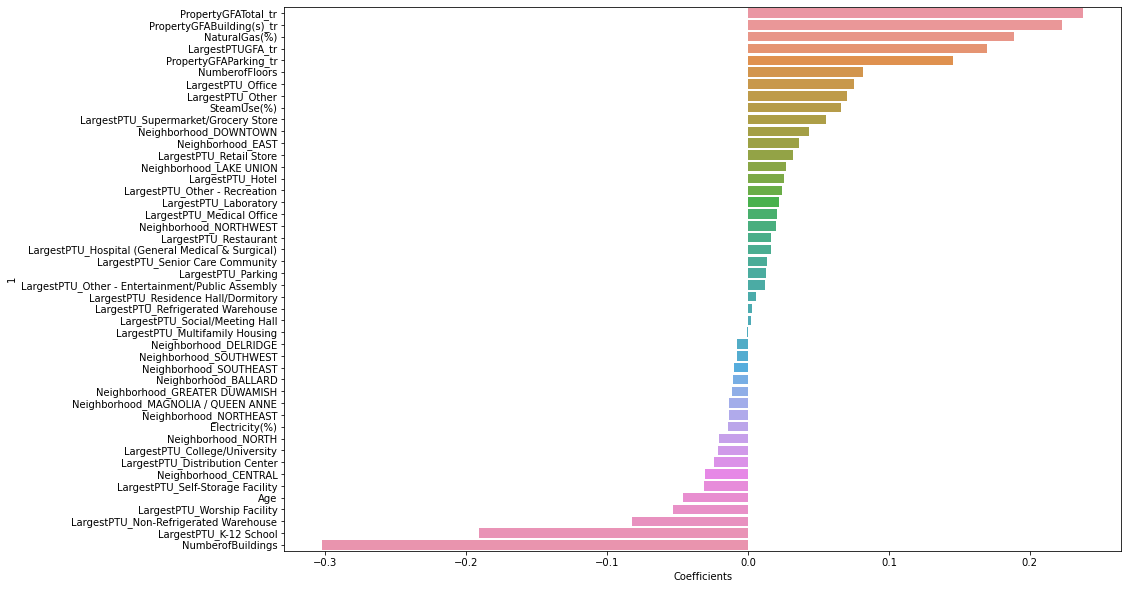

In [32]:
fig, ax1 =plt.subplots(figsize=(15,10))
sns.barplot(data=coeff, y=coeff.index,x='Coefficients')

[Retour au sommaire](#0)<br>

## V. Lasso Regression <a id="5"></a>

## **Définition du modèle**

On définit un modèle de régression Lasso, avec transformation de la cible `y` en log :

In [33]:
regressor = TransformedTargetRegressor(regressor=linear_model.Lasso(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [34]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__copy_X', 'regressor__fit_intercept', 'regressor__max_iter', 'regressor__normalize', 'regressor__positive', 'regressor__precompute', 'regressor__random_state', 'regressor__selection', 'regressor__tol', 'regressor__warm_start', 'regressor', 'transformer'])

In [35]:
# set different regularisation strengths
n_alphas = 300
alphas = np.logspace(-5, 0, n_alphas)

param_grid = {
    'regressor__alpha': alphas,
    'regressor__max_iter' :[10000]
}

In [36]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    param_grid=param_grid, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    cv=5, 
    verbose=True,
    refit='r2',
    return_train_score=True
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Wall time: 1min 48s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Lasso()),
             param_grid={'regressor__alpha': array([1.00000000e-05, 1.03925568e-05, 1.08005237e-05, 1.12245057e-05,
       1.16651313e-05, 1.21230540e-05, 1.25989528e-05, 1.30935333e-05,
       1.36075289e-05, 1.41417017e-05, 1.46968439e-05, 1.52737785e-05,
       1.58733611...
       5.61259726e-01, 5.83292359e-01, 6.06189899e-01, 6.29986298e-01,
       6.54716840e-01, 6.80418197e-01, 7.07128478e-01, 7.34887289e-01,
       7.63735792e-01, 7.93716762e-01, 8.24874655e-01, 8.57255673e-01,
       8.90907830e-01, 9.25881025e-01, 9.62227117e-01, 1.00000000e+00]),
                         'regressor__max_iter': [10000]},
             refit='r2', return_train_score=True,
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [37]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,197,198,199,200,201,202,203,204,205,196,...,9,8,7,6,5,4,3,2,1,0
mean_fit_time,0.018753,0.018358,0.018152,0.018962,0.018948,0.018758,0.018015,0.017598,0.017554,0.021126,...,0.464055,0.506103,0.491331,0.529101,0.590772,0.56075,0.611875,0.613981,0.648948,0.678638
std_fit_time,0.00172,0.002241,0.001716,0.002183,0.00328,0.002401,0.002742,0.002637,0.003128,0.002763,...,0.179066,0.186806,0.15557,0.182901,0.203625,0.203841,0.25117,0.23549,0.238083,0.250092
mean_score_time,0.000398,0.000597,0.00079,0.000992,0.000997,0.000804,0.000391,0.000599,0.000796,0.000603,...,0.003124,0.0006,0.000593,0.000596,0.000796,0.000398,0.003525,0.000401,0.000606,0.000199
std_score_time,0.000487,0.000487,0.000395,0.000008,0.000001,0.000402,0.000479,0.000798,0.000398,0.000493,...,0.006249,0.00049,0.000484,0.000486,0.000399,0.000488,0.006065,0.000492,0.000495,0.000399
param_regressor__alpha,0.019693,0.020466,0.02127,0.022105,0.022972,0.023874,0.024811,0.025785,0.026797,0.018949,...,0.000014,0.000014,0.000013,0.000013,0.000012,0.000012,0.000011,0.000011,0.00001,0.00001
param_regressor__max_iter,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
params,"{'regressor__alpha': 0.019693113379074218, 're...","{'regressor__alpha': 0.0204661799939199, 'regr...","{'regressor__alpha': 0.0212695938666869, 'regr...","{'regressor__alpha': 0.022104546299710218, 're...","{'regressor__alpha': 0.022972275360711513, 're...","{'regressor__alpha': 0.02387406771860647, 'reg...","{'regressor__alpha': 0.024811260551377678, 're...","{'regressor__alpha': 0.025785243528842736, 're...","{'regressor__alpha': 0.026797460873256896, 're...","{'regressor__alpha': 0.018949247718738217, 're...",...,"{'regressor__alpha': 1.414170170289024e-05, 'r...","{'regressor__alpha': 1.3607528864243332e-05, '...","{'regressor__alpha': 1.3093533273536095e-05, '...","{'regressor__alpha': 1.2598952777950285e-05, '...","{'regressor__alpha': 1.2123054013376529e-05, '...","{'regressor__alpha': 1.1665131316981961e-05, '...","{'regressor__alpha': 1.1224505680853058e-05, '...","{'regressor__alpha': 1.080052374516254e-05, 'r...","{'regressor__alpha': 1.039255682936713e-05, 'r...","{'regressor__alpha': 1e-05, 'regressor__max_it..."
split0_test_r2,0.165699,0.164281,0.162894,0.161458,0.159971,0.158432,0.156779,0.155151,0.153507,0.167454,...,0.343655,0.343669,0.343684,0.343697,0.343711,0.343723,0.343736,0.343747,0.343759,0.34377
split1_test_r2,0.204379,0.201469,0.19865,0.196065,0.193359,0.190974,0.188393,0.185368,0.181634,0.207184,...,0.179972,0.179913,0.179856,0.179801,0.179748,0.179698,0.179649,0.179602,0.179557,0.179513
split2_test_r2,0.379651,0.373763,0.367583,0.361094,0.354275,0.347184,0.339801,0.331875,0.32354,0.254224,...,-128852279126637199360.0,-129057820518782582784.0,-129255908308619624448.0,-129446797523303612416.0,-129630753788809854976.0,-129807998563361505280.0,-129978779905434189824.0,-130143323049098166272.0,-130301859180097798144.0,-130454581641401778176.0


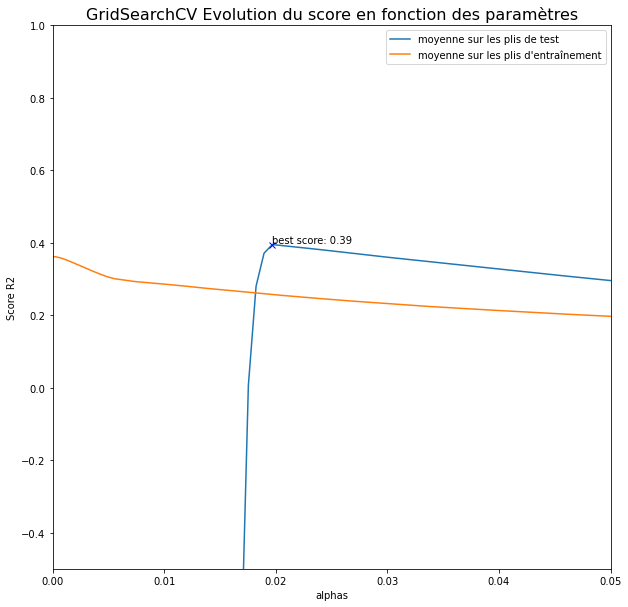

In [38]:
results=pd.DataFrame(grid_search.cv_results_)
fig1, ax =plt.subplots(figsize=(10,10))

plt.title("GridSearchCV Evolution du score en fonction des paramètres", fontsize=16)
plt.xlabel("alphas")
plt.ylabel("Score R2")

ax.set_xlim(0, 0.05)
ax.set_ylim(-0.5, 1)

ax.plot(results['param_regressor__alpha'], results['mean_test_r2'], label='moyenne sur les plis de test')
ax.plot(results['param_regressor__alpha'], results['mean_train_r2'], label="moyenne sur les plis d'entraînement" )
plt.legend(loc="best")

ax.plot(grid_search.best_params_['regressor__alpha'], grid_search.best_score_, marker='x', color='b')

 # Annotate the best score for that scorer
ax.annotate("best score: %0.2f" % grid_search.best_score_, (grid_search.best_params_['regressor__alpha'], grid_search.best_score_+0.005))

plt.show()

On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [39]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Lasso(alpha=0.019693113379074218,
                                           max_iter=10000))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [40]:
best_regressor.regressor_.get_params()

{'alpha': 0.019693113379074218,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 10000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [41]:
grid_search.best_score_

0.39473222986030343

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [42]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [43]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/consommation moyenne: %.2f" % (np.sqrt(error_train)/conso_moy_train))
print("MAE entrainement/consommation moyenne:: %.2f" % (mae_train/conso_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/consommation moyenne:: %.2f" % (np.sqrt( error_test)/conso_moy_test))
print("MAE test/consommation moyenne:: %.2f" % (mae_test/conso_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/consommation moyenne: 2.41
MAE entrainement/consommation moyenne:: 0.54
Coefficient de determination entrainement: 0.25 

RMSE test/consommation moyenne:: 2.21
MAE test/consommation moyenne:: 0.56
Coefficient de determination test: 0.27


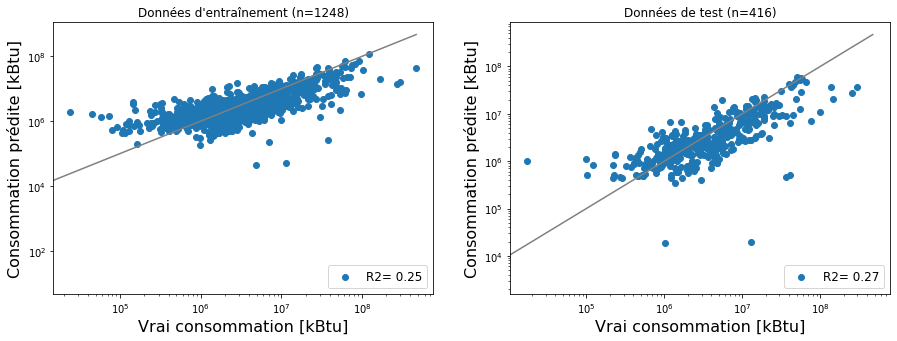

In [44]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vrai consommation [kBtu]', fontsize=16)
    ax.set_ylabel(u'Consommation prédite [kBtu]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## Analyse des variables qui influent le plus sur la regression

In [45]:
coeff=pd.DataFrame(best_regressor.regressor_.coef_, features, columns=['Coefficients']).sort_values('Coefficients', ascending=False)

<AxesSubplot:xlabel='Coefficients', ylabel='1'>

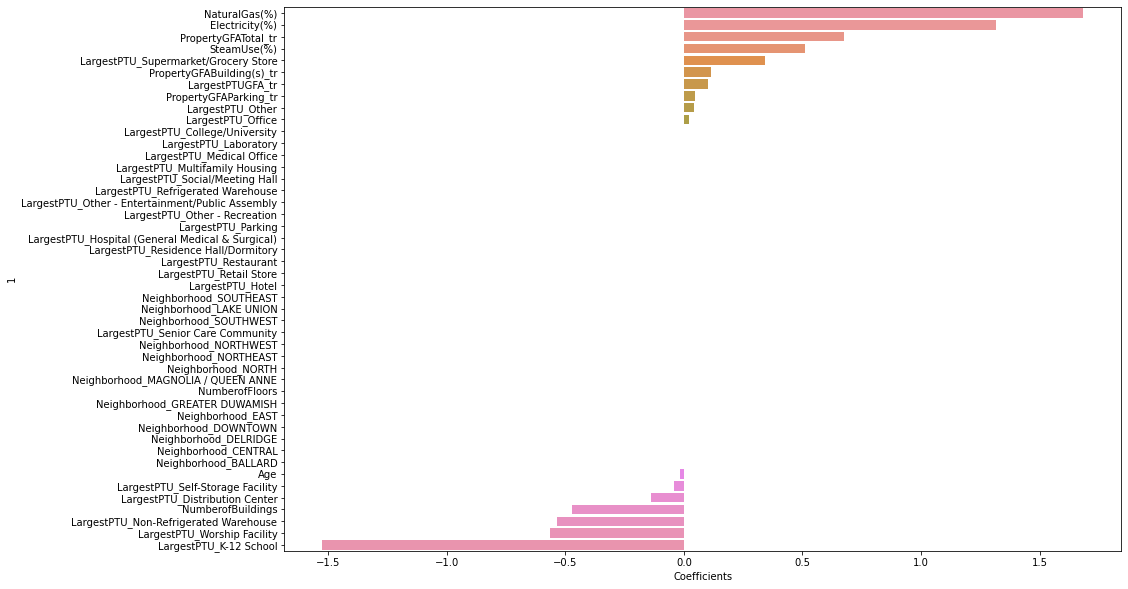

In [46]:
fig, ax1 =plt.subplots(figsize=(15,10))
sns.barplot(data=coeff, y=coeff.index,x='Coefficients')

[Retour au sommaire](#0)<br>

# VI. Régression ridge à noyau <a id="6"></a>


## **Définition du modèle**

On définit un modèle de régression KernelRidge, avec transformation de la cible `y` en log :

In [47]:
regressor = TransformedTargetRegressor(regressor=KernelRidge(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [48]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__coef0', 'regressor__degree', 'regressor__gamma', 'regressor__kernel', 'regressor__kernel_params', 'regressor', 'transformer'])

In [49]:
# set different regularisation strengths
alphas = np.logspace(-3, 0, 10)
gammas=np.logspace(-6, -3, 10)

param_grid = {
    'regressor__alpha': alphas,
    'regressor__degree':[2,3],
    'regressor__gamma' :gammas,
    'regressor__kernel':['rbf','polynomial']
}

In [50]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    param_grid=param_grid, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    cv=5, 
    verbose=True,
    refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Wall time: 2min 15s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=KernelRidge()),
             param_grid={'regressor__alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                         'regressor__degree': [2, 3],
                         'regressor__gamma': array([1.00000000e-06, 2.15443469e-06, 4.64158883e-06, 1.00000000e-05,
       2.15443469e-05, 4.64158883e-05, 1.00000000e-04, 2.15443469e-04,
       4.64158883e-04, 1.00000000e-03]),
                         'regressor__kernel': ['rbf', 'polynomial']},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [51]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,198,178,138,158,196,176,156,136,238,218,...,77,15,35,17,59,119,37,19,79,39
mean_fit_time,0.047081,0.064794,0.064795,0.060734,0.05006,0.070212,0.055449,0.050876,0.048669,0.063044,...,0.066032,0.042278,0.062832,0.039882,0.038696,0.081978,0.069408,0.042885,0.070719,0.070659
std_fit_time,0.00269,0.007664,0.003881,0.007501,0.003654,0.005224,0.008737,0.006942,0.0075,0.00894,...,0.002474,0.006377,0.001093,0.002904,0.00359,0.008221,0.004114,0.003784,0.008084,0.005812
mean_score_time,0.009375,0.014608,0.012764,0.013907,0.00958,0.012567,0.00765,0.01263,0.010772,0.013354,...,0.014541,0.008187,0.013365,0.008589,0.007979,0.018951,0.014362,0.008381,0.015359,0.014965
std_score_time,0.000783,0.001149,0.001164,0.002215,0.001848,0.001493,0.006663,0.008554,0.002309,0.001362,...,0.000786,0.001176,0.000489,0.001352,0.001093,0.003464,0.001849,0.001357,0.00272,0.002279
param_regressor__alpha,0.021544,0.021544,0.01,0.01,0.021544,0.021544,0.01,0.01,0.046416,0.046416,...,0.002154,0.001,0.001,0.001,0.002154,0.004642,0.001,0.001,0.002154,0.001
param_regressor__degree,3,2,2,3,3,2,3,2,3,2,...,3,2,3,2,2,3,3,2,3,3
param_regressor__gamma,0.001,0.001,0.001,0.001,0.000464,0.000464,0.000464,0.000464,0.001,0.001,...,0.000464,0.000215,0.000215,0.000464,0.001,0.001,0.000464,0.001,0.001,0.001
param_regressor__kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,polynomial,polynomial,polynomial,polynomial,polynomial,polynomial,polynomial,polynomial,polynomial,polynomial
params,"{'regressor__alpha': 0.021544346900318832, 're...","{'regressor__alpha': 0.021544346900318832, 're...","{'regressor__alpha': 0.01, 'regressor__degree'...","{'regressor__alpha': 0.01, 'regressor__degree'...","{'regressor__alpha': 0.021544346900318832, 're...","{'regressor__alpha': 0.021544346900318832, 're...","{'regressor__alpha': 0.01, 'regressor__degree'...","{'regressor__alpha': 0.01, 'regressor__degree'...","{'regressor__alpha': 0.046415888336127774, 're...","{'regressor__alpha': 0.046415888336127774, 're...",...,"{'regressor__alpha': 0.0021544346900318843, 'r...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.0021544346900318843, 'r...","{'regressor__alpha': 0.004641588833612777, 're...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.001, 'regressor__degree...","{'regressor__alpha': 0.0021544346900318843, 'r...","{'regressor__alpha': 0.001, 'regressor__degree..."
split0_test_r2,0.196382,0.196382,0.213566,0.213566,0.186447,0.186447,0.208603,0.208603,0.177582,0.177582,...,0.249533,0.260346,0.25531,0.257849,0.257523,0.255125,0.266162,0.28004,0.288141,0.329988


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [52]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=KernelRidge(alpha=0.021544346900318832,
                                                 degree=2, gamma=0.001,
                                                 kernel='rbf'))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [53]:
best_regressor.regressor_.get_params()

{'alpha': 0.021544346900318832,
 'coef0': 1,
 'degree': 2,
 'gamma': 0.001,
 'kernel': 'rbf',
 'kernel_params': None}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [54]:
grid_search.best_score_

0.492943332995039

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [55]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [56]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/consommation moyenne: %.2f" % (np.sqrt(error_train)/conso_moy_train))
print("MAE entrainement/consommation moyenne:: %.2f" % (mae_train/conso_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/consommation moyenne:: %.2f" % (np.sqrt( error_test)/conso_moy_test))
print("MAE test/consommation moyenne:: %.2f" % (mae_test/conso_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/consommation moyenne: 2.21
MAE entrainement/consommation moyenne:: 0.49
Coefficient de determination entrainement: 0.37 

RMSE test/consommation moyenne:: 1.41
MAE test/consommation moyenne:: 0.44
Coefficient de determination test: 0.70


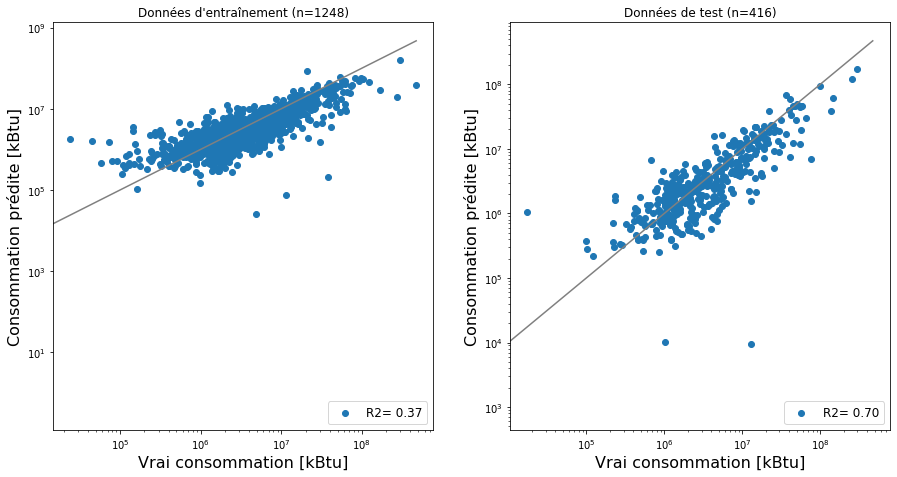

In [57]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 7.5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vrai consommation [kBtu]', fontsize=16)
    ax.set_ylabel(u'Consommation prédite [kBtu]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

[Retour au sommaire](#0)<br>

## VII. Arbre de décision <a id="7"></a>

In [58]:
dtree=DecisionTreeRegressor()

In [59]:
#paramètres pour la recherche
param_grid = {
    "max_depth": [4,5,6,7],
    "min_samples_split":[2,5,10,15,20],
    "min_samples_leaf":[5,10,15,20],
    }

In [60]:
%%time

grid_search = GridSearchCV(
    estimator=dtree, 
    param_grid=param_grid, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    cv=5, 
    verbose=True,
    refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Wall time: 1.68 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15, 20]},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [61]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,31,32,34,33,30,50,51,52,53,54,...,40,61,20,21,22,1,42,41,60,62
mean_fit_time,0.002995,0.00299,0.002994,0.002784,0.002992,0.003383,0.00339,0.00359,0.003191,0.00339,...,0.003591,0.004587,0.002993,0.002995,0.003392,0.002593,0.00359,0.00379,0.003989,0.003989
std_fit_time,0.000003,0.000004,0.000002,0.000391,0.000001,0.000478,0.000489,0.000489,0.000399,0.000489,...,0.00049,0.000489,0.000001,0.000634,0.000488,0.000489,0.000488,0.0004,0.0,0.0
mean_score_time,0.000795,0.000599,0.000597,0.001006,0.000599,0.000598,0.000798,0.000798,0.000798,0.000599,...,0.000598,0.000399,0.000598,0.000399,0.000598,0.000798,0.000598,0.000599,0.000998,0.000399
std_score_time,0.000398,0.000489,0.000487,0.000015,0.000489,0.000488,0.000399,0.000399,0.000399,0.000489,...,0.000488,0.000489,0.000488,0.000489,0.000489,0.000399,0.000488,0.000489,0.0,0.000489
param_max_depth,5,5,5,5,5,6,6,6,6,6,...,6,7,5,5,5,4,6,6,7,7
param_min_samples_leaf,15,15,15,15,15,15,15,15,15,15,...,5,5,5,5,5,5,5,5,5,5
param_min_samples_split,5,10,20,15,2,2,5,10,15,20,...,2,5,2,5,10,5,10,5,2,10
params,"{'max_depth': 5, 'min_samples_leaf': 15, 'min_...","{'max_depth': 5, 'min_samples_leaf': 15, 'min_...","{'max_depth': 5, 'min_samples_leaf': 15, 'min_...","{'max_depth': 5, 'min_samples_leaf': 15, 'min_...","{'max_depth': 5, 'min_samples_leaf': 15, 'min_...","{'max_depth': 6, 'min_samples_leaf': 15, 'min_...","{'max_depth': 6, 'min_samples_leaf': 15, 'min_...","{'max_depth': 6, 'min_samples_leaf': 15, 'min_...","{'max_depth': 6, 'min_samples_leaf': 15, 'min_...","{'max_depth': 6, 'min_samples_leaf': 15, 'min_...",...,"{'max_depth': 6, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 7, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 4, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 6, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 6, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 7, 'min_samples_leaf': 5, 'min_s...","{'max_depth': 7, 'min_samples_leaf': 5, 'min_s..."
split0_test_r2,0.296872,0.296872,0.296872,0.296872,0.296872,0.29326,0.29326,0.29326,0.29326,0.29326,...,0.278556,0.257996,0.26695,0.26695,0.26695,0.264326,0.278556,0.278556,0.257996,0.257996
split1_test_r2,0.298875,0.298875,0.298875,0.298875,0.298875,0.297931,0.297931,0.297931,0.297931,0.297931,...,0.180612,0.176733,0.185384,0.185384,0.185384,0.162142,0.180612,0.180612,0.176733,0.176733


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [62]:
best_regressor = grid_search.best_estimator_
best_regressor

DecisionTreeRegressor(max_depth=5, min_samples_leaf=15)

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [63]:
best_regressor.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [64]:
grid_search.best_score_

0.4286676791796725

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [65]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [66]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/consommation moyenne: %.2f" % (np.sqrt(error_train)/conso_moy_train))
print("MAE entrainement/consommation moyenne:: %.2f" % (mae_train/conso_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/consommation moyenne:: %.2f" % (np.sqrt( error_test)/conso_moy_test))
print("MAE test/consommation moyenne:: %.2f" % (mae_test/conso_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/consommation moyenne: 2.17
MAE entrainement/consommation moyenne:: 0.57
Coefficient de determination entrainement: 0.39 

RMSE test/consommation moyenne:: 1.88
MAE test/consommation moyenne:: 0.62
Coefficient de determination test: 0.47


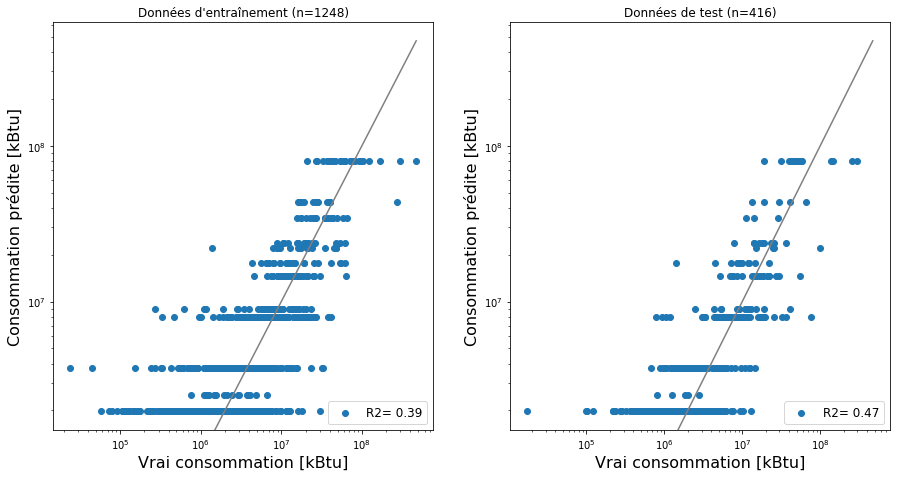

In [67]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 7.5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vrai consommation [kBtu]', fontsize=16)
    ax.set_ylabel(u'Consommation prédite [kBtu]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

[Retour au sommaire](#0)<br>

# VIII. Gradient boosting regression <a id="8"></a>

## **Définition du modèle**

On définit un modèle de régression qui est un GradientBoostingRegressor(), avec transformation de la cible `y` en log :

In [68]:
regressor = TransformedTargetRegressor(regressor=GradientBoostingRegressor(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [69]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__init', 'regressor__learning_rate', 'regressor__loss', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__min_impurity_decrease', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_iter_no_change', 'regressor__random_state', 'regressor__subsample', 'regressor__tol', 'regressor__validation_fraction', 'regressor__verbose', 'regressor__warm_start', 'regressor', 'transformer'])

In [70]:
# set different regularisation strengths
learning_rates = np.logspace(-3, 0, 10)

#paramètres pour la recherche
param_grid = {
    "regressor__n_estimators": [100,500],
    "regressor__max_depth": [3,4,5],
    "regressor__learning_rate": learning_rates,
}

In [71]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    param_grid=param_grid, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    cv=5, 
    verbose=True,
    refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 3min 10s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=GradientBoostingRegressor()),
             param_grid={'regressor__learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                         'regressor__max_depth': [3, 4, 5],
                         'regressor__n_estimators': [100, 500]},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [72]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,42,43,38,31,27,33,40,29,45,36,...,6,4,2,0,57,56,54,55,58,59
mean_fit_time,0.154236,0.82711,0.20416,0.788198,1.01564,1.041113,0.262196,1.286864,1.085771,0.163763,...,0.162958,0.282521,0.220103,0.164878,1.038031,0.20705,0.158286,0.786981,0.26908,1.135001
std_fit_time,0.000537,0.034635,0.001693,0.016281,0.003103,0.011404,0.007287,0.017422,0.041287,0.004342,...,0.005136,0.008349,0.006864,0.005577,0.01435,0.001351,0.002189,0.014195,0.007735,0.046058
mean_score_time,0.0012,0.004006,0.001394,0.00419,0.005587,0.005383,0.001865,0.00738,0.005006,0.001206,...,0.001596,0.00138,0.001206,0.001005,0.005186,0.001796,0.001196,0.003793,0.001795,0.006594
std_score_time,0.000397,0.000617,0.000489,0.000398,0.000801,0.00049,0.000267,0.000489,0.000015,0.000396,...,0.000488,0.000483,0.000408,0.000015,0.000399,0.000399,0.000399,0.000401,0.000399,0.000493
param_regressor__learning_rate,0.215443,0.215443,0.1,0.046416,0.021544,0.046416,0.1,0.021544,0.215443,0.1,...,0.002154,0.001,0.001,0.001,1.0,1.0,1.0,1.0,1.0,1.0
param_regressor__max_depth,3,3,4,3,4,4,5,5,4,3,...,3,5,4,3,4,4,3,3,5,5
param_regressor__n_estimators,100,500,100,500,500,500,100,500,500,100,...,100,100,100,100,500,100,100,500,100,500
params,{'regressor__learning_rate': 0.215443469003188...,{'regressor__learning_rate': 0.215443469003188...,"{'regressor__learning_rate': 0.1, 'regressor__...",{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.021544346900318...,{'regressor__learning_rate': 0.046415888336127...,"{'regressor__learning_rate': 0.1, 'regressor__...",{'regressor__learning_rate': 0.021544346900318...,{'regressor__learning_rate': 0.215443469003188...,"{'regressor__learning_rate': 0.1, 'regressor__...",...,{'regressor__learning_rate': 0.002154434690031...,"{'regressor__learning_rate': 0.001, 'regressor...","{'regressor__learning_rate': 0.001, 'regressor...","{'regressor__learning_rate': 0.001, 'regressor...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__..."
split0_test_r2,0.38797,0.462493,0.350575,0.366771,0.341573,0.412288,0.445061,0.376733,0.427896,0.32352,...,-0.057186,-0.062729,-0.062527,-0.065881,-2.060699,-0.576959,-75.106183,-41.460337,-430.878978,-412.32598
split1_test_r2,0.140044,0.115314,0.212645,0.192955,0.172112,0.125977,0.132939,0.127153,0.099267,0.189699,...,-0.032764,-0.035292,-0.03672,-0.038461,-5.759286,-5.897148,0.000489,0.003504,-173301.832227,-177450.032524


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [73]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GradientBoostingRegressor(learning_rate=0.21544346900318823))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [74]:
best_regressor.regressor_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.21544346900318823,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [75]:
grid_search.best_score_

0.5668071365072189

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [76]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [77]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/consommation moyenne: %.2f" % (np.sqrt(error_train)/conso_moy_train))
print("MAE entrainement/consommation moyenne:: %.2f" % (mae_train/conso_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/consommation moyenne:: %.2f" % (np.sqrt( error_test)/conso_moy_test))
print("MAE test/consommation moyenne:: %.2f" % (mae_test/conso_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/consommation moyenne: 1.16
MAE entrainement/consommation moyenne:: 0.31
Coefficient de determination entrainement: 0.83 

RMSE test/consommation moyenne:: 1.10
MAE test/consommation moyenne:: 0.38
Coefficient de determination test: 0.82


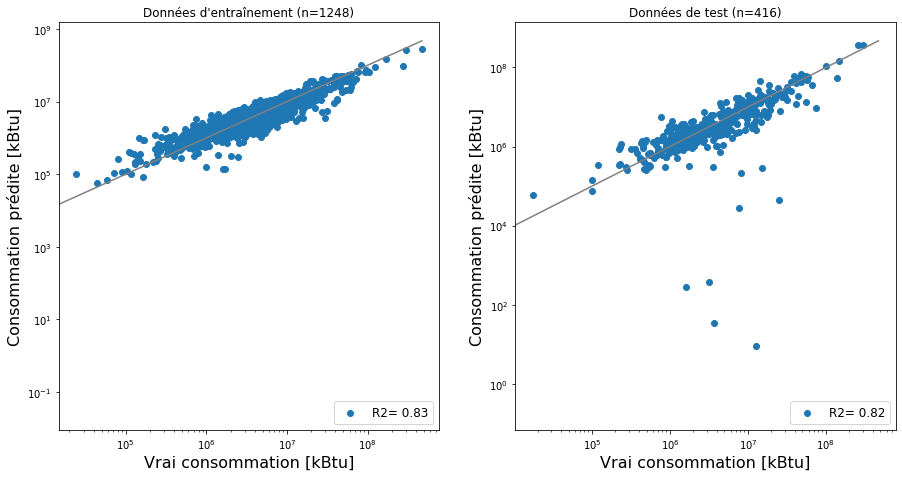

In [78]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 7.5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vrai consommation [kBtu]', fontsize=16)
    ax.set_ylabel(u'Consommation prédite [kBtu]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## Analyse des variables qui influent le plus sur la regression

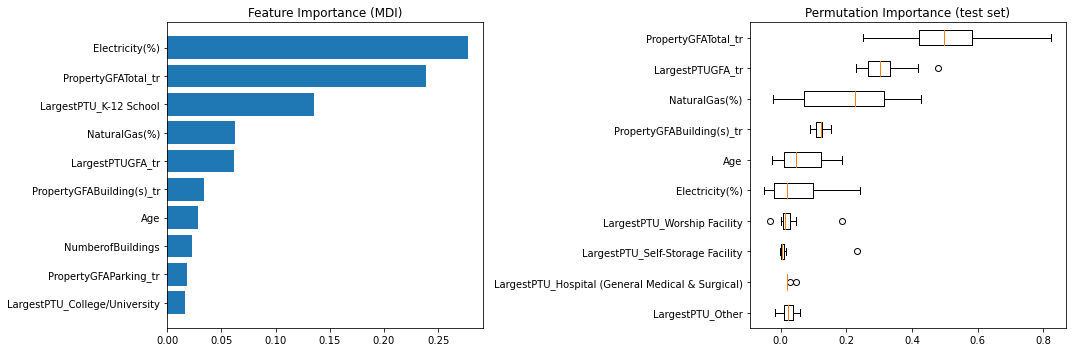

In [79]:
fig = plt.figure(figsize=(15, 5))

# Compute and plot feature importance 1
plt.subplot(1, 2, 1)
feature_importance = best_regressor.regressor_.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title("Feature Importance (MDI)") #MDI=mean decrease in impurity

# Compute and plot feature importance 2
plt.subplot(1, 2, 2)
result = permutation_importance(best_regressor, X_CO2_test_tr.toarray(), y_CO2_test, n_repeats=10)
sorted_idx = result.importances_mean.argsort()[-10:]
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(features)[sorted_idx])
plt.title("Permutation Importance (test set)")

fig.tight_layout()

[Retour au sommaire](#0)<br>

# IX. Evaluation intérêt énergie star <a id="9"></a>

Dans cette section nous allons intégrer la variable EnergyStarScore et évaluer si elle permet d'améliorer notre meilleur modèle.

## A. Modèle avec Energy Star

### Préparation des données

crééons un dataframe avec toutes les valeurs non-nulles de sur la variable énergie Star

In [80]:
benchmark_star=benchmark_NR.loc[benchmark_NR['ENERGYSTARScore'].notnull()]

In [81]:
#sélection des colonnes
col_x=['Neighborhood',
    'NumberofBuildings',
    'NumberofFloors', 
    'LargestPropertyUseType', 
    'SteamUse(%)', 
    'Electricity(%)', 
    'NaturalGas(%)', 
    'Age',
    'PropertyGFATotal_tr', 
    'PropertyGFABuilding(s)_tr', 
    'PropertyGFAParking_tr', 
    'LargestPropertyUseTypeGFA_tr',
    'ENERGYSTARScore' 
      ]
X_CO2=benchmark_star.loc[:,col_x]
y_CO2=benchmark_star.loc[:,'SiteEnergyUseWN(kBtu)']

**train_test split**

In [82]:
X_CO2_train,X_CO2_test,y_CO2_train,y_CO2_test=train_test_split(X_CO2,y_CO2, test_size=0.25, random_state=2022)
X_CO2_train.shape

(819, 13)

**Normalisation des variables numériques & encodage des variables catégorielles**

Nous allons utiliser OneHotEncoder pour transformer les variables catégorielles en dummy variable et procéder au centrage et à la réduction des données numériques

In [83]:
ct = make_column_transformer(
    (preprocessing.StandardScaler(),
     make_column_selector(dtype_include=np.number)),  # colonnes numériques
    (OneHotEncoder(handle_unknown='ignore'),
     make_column_selector(dtype_include=object)))  # colonnes catégorie

X_CO2_train_tr=ct.fit_transform(X_CO2_train) 
X_CO2_test_tr=ct.transform(X_CO2_test)

Afin d'améliorer la lisibilité récupérons les noms des features et simplifions les noms

In [84]:
# récupérons les noms des features
features=pd.Series(ct.get_feature_names_out()).str.replace('PropertyUseType', 'PTU').str.split('__', expand=True).loc[:,1]

## **Définition du modèle**

On définit un modèle de régression qui est un GradientBoostingRegressor(), avec transformation de la cible `y` en log :

In [85]:
regressor = TransformedTargetRegressor(regressor=GradientBoostingRegressor(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [86]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__init', 'regressor__learning_rate', 'regressor__loss', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__min_impurity_decrease', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_iter_no_change', 'regressor__random_state', 'regressor__subsample', 'regressor__tol', 'regressor__validation_fraction', 'regressor__verbose', 'regressor__warm_start', 'regressor', 'transformer'])

In [87]:
# set different regularisation strengths
learning_rates = np.logspace(-3, 0, 10)

#paramètres pour la recherche
param_grid = {
    "regressor__n_estimators": [100,500],
    "regressor__max_depth": [3,4,5],
    "regressor__learning_rate": learning_rates,
}

In [88]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    param_grid=param_grid, 
    cv=5, 
    verbose=True,
    refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 2min 7s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=GradientBoostingRegressor()),
             param_grid={'regressor__learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                         'regressor__max_depth': [3, 4, 5],
                         'regressor__n_estimators': [100, 500]},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [89]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,37,34,25,35,45,36,31,27,33,44,...,8,0,4,2,58,59,56,57,54,55
mean_fit_time,0.566331,0.172953,0.545344,0.855344,0.728149,0.110119,0.546938,0.697178,0.726363,0.143815,...,0.143816,0.112308,0.175304,0.139633,0.175357,0.444305,0.146191,0.623173,0.112353,0.578569
std_fit_time,0.00697,0.001642,0.002476,0.002537,0.011567,0.000518,0.005559,0.003524,0.026772,0.000983,...,0.001157,0.002655,0.001475,0.000014,0.003305,0.005305,0.00249,0.008361,0.003926,0.011415
mean_score_time,0.001397,0.0012,0.001795,0.002397,0.0022,0.000995,0.001795,0.001994,0.002194,0.000792,...,0.001197,0.000997,0.000997,0.000997,0.001198,0.001794,0.001006,0.001995,0.001166,0.001395
std_score_time,0.000488,0.000397,0.000399,0.000485,0.000389,0.000626,0.000399,0.000002,0.000399,0.000396,...,0.000399,0.0,0.000001,0.0,0.000399,0.0004,0.000016,0.000002,0.001407,0.00049
param_regressor__learning_rate,0.1,0.046416,0.021544,0.046416,0.215443,0.1,0.046416,0.021544,0.046416,0.215443,...,0.002154,0.001,0.001,0.001,1.0,1.0,1.0,1.0,1.0,1.0
param_regressor__max_depth,3,5,3,5,4,3,3,4,4,4,...,4,3,5,4,5,5,4,4,3,3
param_regressor__n_estimators,500,100,500,500,500,100,500,500,500,100,...,100,100,100,100,100,500,100,500,100,500
params,"{'regressor__learning_rate': 0.1, 'regressor__...",{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.021544346900318...,{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.215443469003188...,"{'regressor__learning_rate': 0.1, 'regressor__...",{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.021544346900318...,{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.215443469003188...,...,{'regressor__learning_rate': 0.002154434690031...,"{'regressor__learning_rate': 0.001, 'regressor...","{'regressor__learning_rate': 0.001, 'regressor...","{'regressor__learning_rate': 0.001, 'regressor...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__..."
split0_test_r2,0.903254,0.624031,0.465919,0.460561,0.658738,0.433306,0.502758,0.482275,0.440148,0.434711,...,-0.022545,-0.03812,-0.03827,-0.038584,-0.48133,-0.246109,-9.642102,-6.288227,-804.633321,-1334.193843
split1_test_r2,0.26238,0.258438,0.303871,0.310065,0.296083,0.298295,0.31657,0.322242,0.293018,0.317034,...,-0.009313,-0.017395,-0.016925,-0.017631,0.565864,0.56429,0.229911,0.229715,-98.164059,-90.873195


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [90]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GradientBoostingRegressor(n_estimators=500))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [91]:
best_regressor.regressor_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [92]:
grid_search.best_score_

0.5653505555077054

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [93]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [94]:
conso_moy_train=np.mean(y_CO2_train)
conso_moy_test=np.mean(y_CO2_test)

In [95]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/consommation moyenne: %.2f" % (np.sqrt(error_train)/conso_moy_train))
print("MAE entrainement/consommation moyenne:: %.2f" % (mae_train/conso_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/consommation moyenne:: %.2f" % (np.sqrt( error_test)/conso_moy_test))
print("MAE test/consommation moyenne:: %.2f" % (mae_test/conso_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/consommation moyenne: 0.21
MAE entrainement/consommation moyenne:: 0.08
Coefficient de determination entrainement: 1.00 

RMSE test/consommation moyenne:: 2.10
MAE test/consommation moyenne:: 0.45
Coefficient de determination test: 0.36


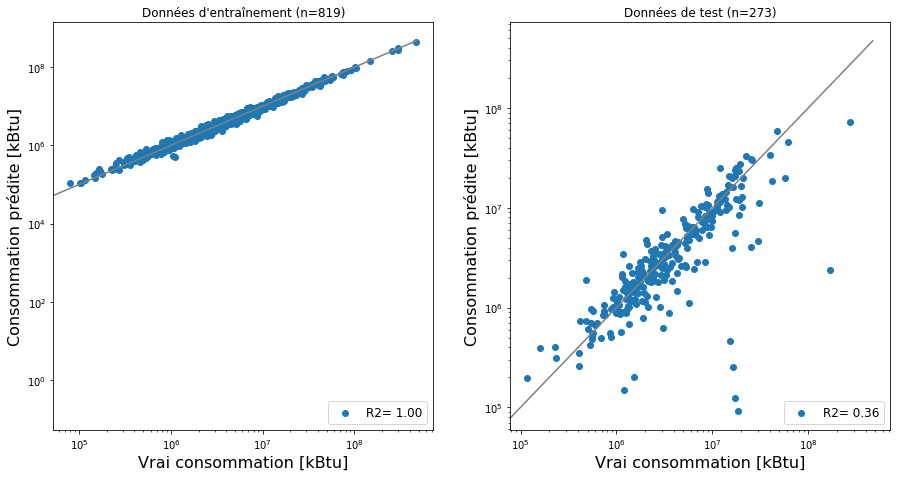

In [96]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 7.5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vrai consommation [kBtu]', fontsize=16)
    ax.set_ylabel(u'Consommation prédite [kBtu]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## Analyse des variables qui influent le plus sur la regression

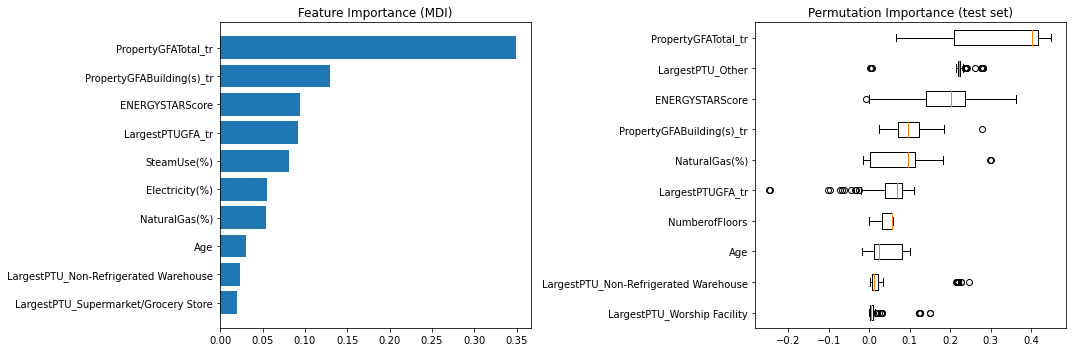

In [97]:
fig = plt.figure(figsize=(15, 5))

# Compute and plot feature importance 1
plt.subplot(1, 2, 1)
feature_importance = best_regressor.regressor_.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title("Feature Importance (MDI)") #MDI=mean decrease in impurity

# Compute and plot feature importance 2
plt.subplot(1, 2, 2)
result = permutation_importance(best_regressor, X_CO2_test_tr, y_CO2_test, n_repeats=100)
sorted_idx = result.importances_mean.argsort()[-10:]
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(features)[sorted_idx])
plt.title("Permutation Importance (test set)")

fig.tight_layout()

[Retour au sommaire](#0)<br>

## B. Modèle sans Energie Star  - Bases comparables

**Suppression de la colonne ENERGYSTARSScore**

In [98]:
X_CO2_train.drop(columns='ENERGYSTARScore', inplace=True)
X_CO2_test.drop(columns='ENERGYSTARScore', inplace=True)

**Normalisation des variables numériques & encodage des variables catégorielles**

Nous allons utiliser OneHotEncoder pour transformer les variables catégorielles en dummy variable et procéder au centrage et à la réduction des données numériques

In [99]:
ct = make_column_transformer(
    (preprocessing.StandardScaler(),
     make_column_selector(dtype_include=np.number)),  # colonnes numériques
    (OneHotEncoder(handle_unknown='ignore'),
     make_column_selector(dtype_include=object)))  # colonnes catégorie

X_CO2_train_tr=ct.fit_transform(X_CO2_train) 
X_CO2_test_tr=ct.transform(X_CO2_test)

Afin d'améliorer la lisibilité récupérons les noms des features et simplifions les noms

In [100]:
# récupérons les noms des features
features=pd.Series(ct.get_feature_names_out()).str.replace('PropertyUseType', 'PTU').str.split('__', expand=True).loc[:,1]

## **Définition du modèle**

On définit un modèle de régression qui est un GradientBoostingRegressor(), avec transformation de la cible `y` en log :

In [101]:
regressor = TransformedTargetRegressor(regressor=GradientBoostingRegressor(), func=np.log1p, inverse_func=np.expm1)

## **Hyper-paramétrisation du modèle par validation croisée**

In [102]:
regressor.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__alpha', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__init', 'regressor__learning_rate', 'regressor__loss', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__min_impurity_decrease', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_iter_no_change', 'regressor__random_state', 'regressor__subsample', 'regressor__tol', 'regressor__validation_fraction', 'regressor__verbose', 'regressor__warm_start', 'regressor', 'transformer'])

In [103]:
# set different regularisation strengths
learning_rates = np.logspace(-3, 0, 10)

#paramètres pour la recherche
param_grid = {
    "regressor__n_estimators": [100,500],
    "regressor__max_depth": [3,4,5],
    "regressor__learning_rate": learning_rates,
}

In [104]:
%%time

grid_search = GridSearchCV(
    estimator=regressor, 
    scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'),
    param_grid=param_grid, 
    cv=5, 
    verbose=True,
    refit='r2'
)


grid_search.fit(X_CO2_train_tr, y_CO2_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 2min 2s


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=GradientBoostingRegressor()),
             param_grid={'regressor__learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                         'regressor__max_depth': [3, 4, 5],
                         'regressor__n_estimators': [100, 500]},
             refit='r2',
             scoring=('r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'),
             verbose=True)

Examinons en détails les résultats de la recherche des meilleurs hyperparamètres : 

In [105]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').T

,30,19,21,17,15,26,34,32,40,28,...,59,43,53,58,49,48,57,54,56,55
mean_fit_time,0.115093,0.561203,0.681105,0.823368,0.638686,0.141655,0.177412,0.137777,0.164823,0.168183,...,0.45382,0.547573,0.822106,0.16775,0.53406,0.106557,0.620727,0.107107,0.13444,0.523274
std_fit_time,0.001354,0.047297,0.051494,0.040729,0.013799,0.006925,0.009942,0.008152,0.002031,0.007871,...,0.012524,0.012714,0.009376,0.002919,0.005611,0.001912,0.008366,0.001359,0.001934,0.006805
mean_score_time,0.001196,0.004322,0.000799,0.004921,0.000801,0.000997,0.001195,0.000799,0.000991,0.000797,...,0.001797,0.001982,0.002805,0.001206,0.001977,0.000999,0.002194,0.000997,0.000998,0.001796
std_score_time,0.000396,0.005705,0.000978,0.005475,0.000981,0.0,0.0004,0.0004,0.000018,0.000399,...,0.0004,0.000885,0.000385,0.000396,0.000018,0.000002,0.000397,0.000001,0.000002,0.0004
param_regressor__learning_rate,0.046416,0.01,0.01,0.004642,0.004642,0.021544,0.046416,0.046416,0.1,0.021544,...,1.0,0.215443,0.464159,1.0,0.464159,0.464159,1.0,1.0,1.0,1.0
param_regressor__max_depth,3,3,4,5,4,4,5,4,5,5,...,5,3,5,5,3,3,4,3,4,3
param_regressor__n_estimators,100,500,500,500,500,100,100,100,100,100,...,500,500,500,100,500,100,500,100,100,500
params,{'regressor__learning_rate': 0.046415888336127...,"{'regressor__learning_rate': 0.01, 'regressor_...","{'regressor__learning_rate': 0.01, 'regressor_...",{'regressor__learning_rate': 0.004641588833612...,{'regressor__learning_rate': 0.004641588833612...,{'regressor__learning_rate': 0.021544346900318...,{'regressor__learning_rate': 0.046415888336127...,{'regressor__learning_rate': 0.046415888336127...,"{'regressor__learning_rate': 0.1, 'regressor__...",{'regressor__learning_rate': 0.021544346900318...,...,"{'regressor__learning_rate': 1.0, 'regressor__...",{'regressor__learning_rate': 0.215443469003188...,{'regressor__learning_rate': 0.464158883361277...,"{'regressor__learning_rate': 1.0, 'regressor__...",{'regressor__learning_rate': 0.464158883361277...,{'regressor__learning_rate': 0.464158883361277...,"{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__...","{'regressor__learning_rate': 1.0, 'regressor__..."
split0_test_r2,0.337365,0.290065,0.365592,0.442779,0.256164,0.263546,0.451324,0.295507,0.504336,0.42599,...,-0.073896,0.580071,0.534958,0.119723,0.369132,0.337763,-0.306518,-6.385663,-0.248176,-23.24036
split1_test_r2,0.201868,0.201305,0.219308,0.150154,0.165865,0.159454,0.195563,0.211344,0.217406,0.147352,...,0.031263,0.195373,0.289947,0.031977,0.15998,0.196052,0.242941,0.050583,0.218555,0.117997


On récupére le meilleur modèle trouvé lors de l'hyperoptimisation : 

In [106]:
best_regressor = grid_search.best_estimator_
best_regressor

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GradientBoostingRegressor(learning_rate=0.046415888336127774))

Les valeurs des hyper-paramètres pour ce meilleur modèle sont : 

In [107]:
best_regressor.regressor_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.046415888336127774,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Pour ce meilleur modèle, la valeur moyenne du score R2 sur les 5 plis de test de la validation croisée est : 

In [108]:
grid_search.best_score_

0.4524905182192035

## Evaluation du modèle

Application du modèle sur le jeu d'entraînement et le jeu de test

In [109]:
y_CO2_pred_test=best_regressor.predict(X_CO2_test_tr) #predictions using the testing set
y_CO2_pred_train=best_regressor.predict(X_CO2_train_tr) #predictions on the train set

Evaluation des performances du modèle

In [110]:
error_test=mean_squared_error(y_CO2_test, y_CO2_pred_test)
error_train=mean_squared_error(y_CO2_train, y_CO2_pred_train)

mae_test=mean_absolute_error(y_CO2_test, y_CO2_pred_test)
mae_train=mean_absolute_error(y_CO2_train, y_CO2_pred_train)

r2_test= r2_score(y_CO2_test, y_CO2_pred_test)
r2_train=r2_score(y_CO2_train, y_CO2_pred_train)


print("RMSE entrainement/consommation moyenne: %.2f" % (np.sqrt(error_train)/conso_moy_train))
print("MAE entrainement/consommation moyenne:: %.2f" % (mae_train/conso_moy_train))
print("Coefficient de determination entrainement: %.2f" % r2_train, '\n')


print("RMSE test/consommation moyenne:: %.2f" % (np.sqrt( error_test)/conso_moy_test))
print("MAE test/consommation moyenne:: %.2f" % (mae_test/conso_moy_test))
print("Coefficient de determination test: %.2f" % r2_test)

RMSE entrainement/consommation moyenne: 1.75
MAE entrainement/consommation moyenne:: 0.38
Coefficient de determination entrainement: 0.67 

RMSE test/consommation moyenne:: 2.41
MAE test/consommation moyenne:: 0.49
Coefficient de determination test: 0.16


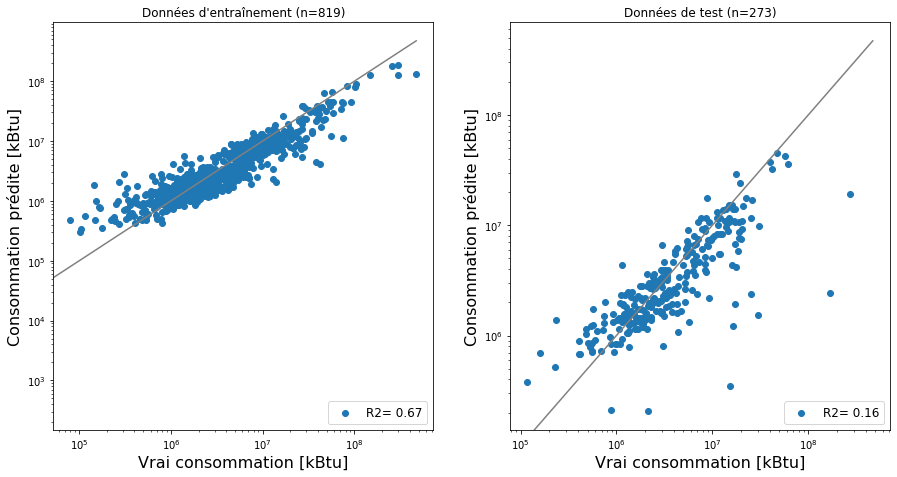

In [111]:
y_min = min([y_CO2_train.min(), y_CO2_pred_train.min(), y_CO2_test.min(), y_CO2_pred_test.min()])
y_max = max([y_CO2_train.max(), y_CO2_pred_train.max(), y_CO2_test.max(), y_CO2_pred_test.max()])

fig, (ax0, ax1) = plt.subplots(figsize=(15, 7.5), ncols=2)
ax0.set_title(f"Données d'entraînement (n={len(y_CO2_pred_train)})")
ax1.set_title(f"Données de test (n={len(y_CO2_pred_test)})")

for y_obs, y_pred, ax in zip((y_CO2_train, y_CO2_test), (y_CO2_pred_train, y_CO2_pred_test), (ax0, ax1)):
    
    r2 = r2_score(y_obs, y_pred)
    ax.scatter(y_obs, y_pred, label="R2= {:.2f}".format(r2))
    ax.plot([y_min, y_max], [y_min, y_max], color='grey')
    ax.legend(loc="lower right", fontsize=12);
    ax.set_xlabel('Vrai consommation [kBtu]', fontsize=16)
    ax.set_ylabel(u'Consommation prédite [kBtu]', fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')

## Analyse des variables qui influent le plus sur la regression

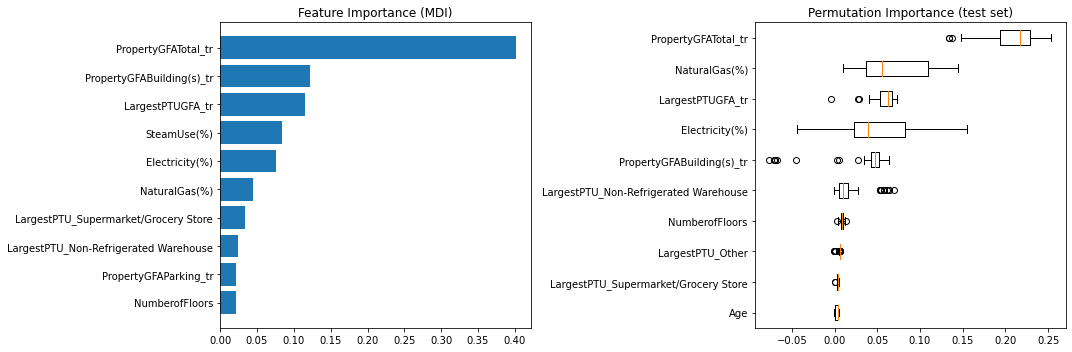

In [112]:
fig = plt.figure(figsize=(15, 5))

# Compute and plot feature importance 1
plt.subplot(1, 2, 1)
feature_importance = best_regressor.regressor_.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title("Feature Importance (MDI)") #MDI=mean decrease in impurity

# Compute and plot feature importance 2
plt.subplot(1, 2, 2)
result = permutation_importance(best_regressor, X_CO2_test_tr, y_CO2_test, n_repeats=100)
sorted_idx = result.importances_mean.argsort()[-10:]
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(features)[sorted_idx])
plt.title("Permutation Importance (test set)")

fig.tight_layout()